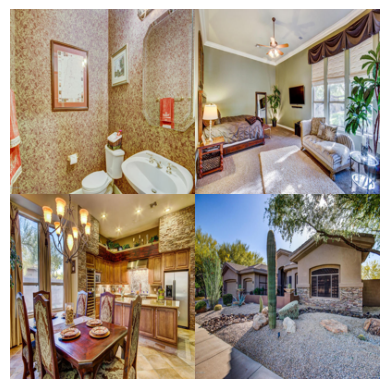

In [3]:
# path to images
bathroom_path = '../dataset/Houses-dataset/Houses Dataset/1_bathroom.jpg'
kitchen_path = '../dataset/Houses-dataset/Houses Dataset/1_kitchen.jpg'
frontal_path = '../dataset/Houses-dataset/Houses Dataset/1_frontal.jpg'
bedroom_path = '../dataset/Houses-dataset/Houses Dataset/1_bedroom.jpg'

# Read imagenes
from PIL import Image

bathroom_image = Image.open(bathroom_path)
bedroom_image = Image.open(bedroom_path)
kitchen_image = Image.open(kitchen_path)
frontal_image = Image.open(frontal_path)

# Resize imagenes
bathroom_image = bathroom_image.resize((200, 200))
bedroom_image = bedroom_image.resize((200, 200))
kitchen_image = kitchen_image.resize((200, 200))
frontal_image = frontal_image.resize((200, 200))

# Create mosaico
mosaic = Image.new('RGB', (400, 400))
mosaic.paste(bathroom_image, (0, 0))
mosaic.paste(bedroom_image, (200, 0))
mosaic.paste(kitchen_image, (0, 200))
mosaic.paste(frontal_image, (200, 200))

# Show mosaico with matplotlib
import matplotlib.pyplot as plt

plt.imshow(mosaic)
plt.axis('off')
plt.show()

In [4]:
from torchvision import transforms

# Create a transform
transform = transforms.Compose([
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
])

# Apply the transform to the images
mosaic = transform(mosaic)


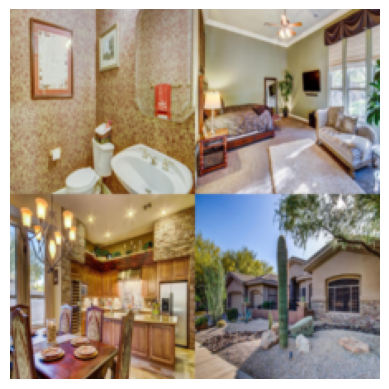

In [5]:
import torch

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

def show_image(image_tensor, title=None, apply_desnormalize=False):
    image_tensor = denormalize(image_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    image_tensor = torch.clamp(image_tensor, 0, 1)
    image = image_tensor.permute(1, 2, 0).cpu().numpy() 
    plt.imshow(image) 
    plt.axis('off')
    plt.show()

show_image(mosaic)